# Zadania
1. Utwórz dwie nowe kolumny w ramce "Countries", w których powierzchnia i gęstość zaludnienia wyrażone sa odpowiednio w milach kwadratowych i osobach na milę kwadratową. 
  - Przelicznik: 1 mila kwadratowa = 0.38610 km kwadratowego (powierzchnię należy pomnożyć, a gęstość zaludnienia podzielić przez ten współczynnik)
  - Typami nowych kolumn mają być odpowiednio integer (powierzchnia) i float (gęstość). Zaokrąglanie do integer: "int(x)"
  - Nazwy nowych kolumn proszę ustawić odpowiednio na '<tt>Area (sq mi)</tt>' oraz '<tt>Pop Density (per sq mi)</tt>'
1. Na wykresie scatterplot narysuj zależność liczby lotnisk od powierzchni kraju. 
  - Dane potrzebne do wykresu są w dwóch ramkach (Countries i Airports), konieczne więc będzie ich złączenie (join).
  - Wskazówka: w pierwszym etapie stwórz ramkę agregującą liczbę lotnisk w zależności od kraju. W drugim etapie złącz (join) tę ramkę z ramką countries. Kolumną wspólną (warunkiem złączenia) będzie Country.
  - Nie zawsze nazwy tych samych krajów będą identyczne w obu ramkach, co może stanowić problem (złączenie nie powstanie). Zastanów się jak przy pomocy mechanizmu złączeń wykryć, które nazwy się różnią. Stwórz odpowiednią ramkę, która zawiera takie nazwy. 
  - Następnie zmień nazwy kilku największych państw w jednej z ramek, tak żeby ujednolicić nazwy. Można to zrobić funkcją replace:
<br><tt>cdf=cdf.replace(['Korea, South', 'Korea, North'], ['South Korea', 'North Korea'], 'Country')</tt>
1. Do ramki "Countries" dodaj nową kolumnę "Continent" (według klasyfikacji Africa, Asia, Europe, North America, South America, Antarctica, Australia/Oceania). 
  - Skorzystaj z kolumny "Region" i pomocniczej funkcji (UDF) mapującej region na kontynent.
1. Oblicz, ile lotnisk jest na poszczególnych kontynentach. To zadanie również wymaga złączenia ramek "Countries" i "Airports". Wynik przedstaw na wykresie słupkowym.


In [1]:
from pyspark.sql import SparkSession

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [6]:
# Wbudowane funkcje, które mogą być przydatne:
# - udf: służy do tworzenia funkcji użytkownika
# - trim: usuwa białe spacje z początku i końca stringu
# - isnull: testuje, czy wartość jest pusta
from pyspark.sql.functions import col, udf, trim, isnull
from pyspark.sql.types import FloatType, IntegerType

In [7]:
def to_float (s) :
   return float(s.replace(',','.'))
float_udf = udf(to_float , FloatType())

In [8]:
countries = spark.read.csv("data/countries of the world.csv",inferSchema=True,header=True)

# Usuwa kropki z wszystkich nazw kolumn (powodują wiele błędów, prawdopodobnie bug w Sparku)
# (Nb. wszystkie inne metody zmiany tych nazw (np. użycie columnRenamed) zawiodły)
new_columns=[s.replace('.','') for s in countries.columns]
countries=countries.toDF(*new_columns) # tutaj '*' to operator "splat" -- robi z tablicy listę argumentów

# Tak można ustawić wyświetlanie większej liczby wierszy w Jupyterze
pd.set_option('display.max_rows', 20)
display(countries.toPandas())

,Country,Region,Population,Area (sq mi),Pop Density (per sq mi),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,None,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",None,None,NaN,None,None,"0,02",0,"99,98",1,None,None,None,None,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


In [9]:
# Utworzenie nowej ramki 'cdf':
# - wartosci puste wypelnione "-1", zeby nie usuwac wierszy
# - trim stringów (w nazwach występują niepożądane spacje na końcu)
# - konwersja wszystkich kolumn zmiennoprzecinkowych na float
# - zmiana 'sq mi' na 'sq km', bo w zbiorze wartości są faktycznie w km^2, a nie milach^2
cdf=countries.na.fill("-1").select( 
                 trim(col('Country')).alias('Country'),\
                 trim(col('Region')).alias('Region'),'Population',\
                 col('`Area (sq mi)`').alias('Area (sq km)'),\
                 float_udf('`Pop Density (per sq mi)`').alias('Pop Density (per sq km)'),\
                 float_udf('Coastline (coast/area ratio)').alias('Coastline (coast/area ratio)'),\
                 float_udf('Net migration').alias('Net migration'),\
                 float_udf('Infant mortality (per 1000 births)').alias('Infant mortality (per 1000 births)'),\
                 'GDP ($ per capita)',\
                 float_udf('Literacy (%)').alias('Literacy (%)'),\
                 float_udf('Phones (per 1000)').alias('Phones (per 1000)'),\
                 float_udf('Arable (%)').alias('Arable (%)'),\
                 float_udf('Crops (%)').alias('Crops (%)'),\
                 float_udf('Other (%)').alias('Other (%)'),\
                 float_udf('Birthrate').alias('Birthrate'),\
                 float_udf('Deathrate').alias('Deathrate'),\
                 float_udf('Agriculture').alias('Agriculture'),\
                 float_udf('Industry').alias('Industry'),\
                 float_udf('Service').alias('Service'))

In [10]:
cdf.show(5)

+--------------+--------------------+----------+------------+-----------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+---------+---------+-----------+--------+-------+
|       Country|              Region|Population|Area (sq km)|Pop Density (per sq km)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Birthrate|Deathrate|Agriculture|Industry|Service|
+--------------+--------------------+----------+------------+-----------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+---------+---------+-----------+--------+-------+
|   Afghanistan|ASIA (EX. NEAR EAST)|  31056997|      647500|                   48.0|                         0.0|    

In [11]:
cdf.printSchema()

root
 |-- Country: string (nullable = false)
 |-- Region: string (nullable = false)
 |-- Population: integer (nullable = true)
 |-- Area (sq km): integer (nullable = true)
 |-- Pop Density (per sq km): float (nullable = true)
 |-- Coastline (coast/area ratio): float (nullable = true)
 |-- Net migration: float (nullable = true)
 |-- Infant mortality (per 1000 births): float (nullable = true)
 |-- GDP ($ per capita): integer (nullable = true)
 |-- Literacy (%): float (nullable = true)
 |-- Phones (per 1000): float (nullable = true)
 |-- Arable (%): float (nullable = true)
 |-- Crops (%): float (nullable = true)
 |-- Other (%): float (nullable = true)
 |-- Birthrate: float (nullable = true)
 |-- Deathrate: float (nullable = true)
 |-- Agriculture: float (nullable = true)
 |-- Industry: float (nullable = true)
 |-- Service: float (nullable = true)



# Zadanie 1: nowe kolumny

In [34]:
# TODO
cdf=cdf.withColumn('Area (sq mi)', (cdf['Area (sq km)']*0.3861).cast(IntegerType()))
cdf=cdf.withColumn('Pop Density (per sq mi)', cdf['Population']/0.3861)

In [35]:
# OR in a single line
cdf=cdf.withColumn('Area (sq mi)', (cdf['Area (sq km)']*0.3861).cast(IntegerType())).\
        withColumn('Pop Density (per sq mi)', cdf['Population']/0.3861)

In [36]:
cdf.select('Country', 'Area (sq mi)', 'Area (sq km)', 'Population', 'Pop Density (per sq mi)').toPandas()

,Country,Area (sq mi),Area (sq km),Population,Pop Density (per sq mi)
0,Afghanistan,249999,647500,31056997,8.043770e+07
1,Albania,11099,28748,3581655,9.276496e+06
2,Algeria,919589,2381740,32930091,8.528902e+07
3,American Samoa,76,199,57794,1.496866e+05
4,Andorra,180,468,71201,1.844108e+05
...,...,...,...,...,...
222,West Bank,2262,5860,2460492,6.372681e+06
223,Western Sahara,102702,266000,273008,7.070914e+05
224,Yemen,203849,527970,21456188,5.557158e+07
225,Zambia,290584,752614,11502010,2.979024e+07


In [37]:
cdf.printSchema()

root
 |-- Country: string (nullable = false)
 |-- Region: string (nullable = false)
 |-- Population: integer (nullable = true)
 |-- Area (sq km): integer (nullable = true)
 |-- Pop Density (per sq km): float (nullable = true)
 |-- Coastline (coast/area ratio): float (nullable = true)
 |-- Net migration: float (nullable = true)
 |-- Infant mortality (per 1000 births): float (nullable = true)
 |-- GDP ($ per capita): integer (nullable = true)
 |-- Literacy (%): float (nullable = true)
 |-- Phones (per 1000): float (nullable = true)
 |-- Arable (%): float (nullable = true)
 |-- Crops (%): float (nullable = true)
 |-- Other (%): float (nullable = true)
 |-- Birthrate: float (nullable = true)
 |-- Deathrate: float (nullable = true)
 |-- Agriculture: float (nullable = true)
 |-- Industry: float (nullable = true)
 |-- Service: float (nullable = true)
 |-- Area (sq mi): integer (nullable = true)
 |-- Pop Density (per sq mi): double (nullable = true)



# Join examples

In [38]:
valuesA = [('Pirate',1),('Monkey',2),('Ninja',3),('Spaghetti',4)]
TableA = spark.createDataFrame(valuesA,['name','id'])
 
valuesB = [('Rutabaga',1),('Pirate',2),('Ninja',3),('Darth Vader',4)]
TableB = spark.createDataFrame(valuesB,['name','id'])

In [39]:
a=TableA.alias('a')
b=TableB.alias('b')

In [40]:
a.join(b, a.name==b.name).show() # how='inner'

+------+---+------+---+
|  name| id|  name| id|
+------+---+------+---+
| Ninja|  3| Ninja|  3|
|Pirate|  1|Pirate|  2|
+------+---+------+---+



In [41]:
a.join(b, a.name==b.name, how='left').show()

+---------+---+------+----+
|     name| id|  name|  id|
+---------+---+------+----+
|Spaghetti|  4|  null|null|
|    Ninja|  3| Ninja|   3|
|   Pirate|  1|Pirate|   2|
|   Monkey|  2|  null|null|
+---------+---+------+----+



In [42]:
a.join(b, a.name==b.name, how='right').show()

+------+----+-----------+---+
|  name|  id|       name| id|
+------+----+-----------+---+
|  null|null|   Rutabaga|  1|
| Ninja|   3|      Ninja|  3|
|Pirate|   1|     Pirate|  2|
|  null|null|Darth Vader|  4|
+------+----+-----------+---+



In [43]:
a.join(b, a.name==b.name, how='full_outer').show()

+---------+----+-----------+----+
|     name|  id|       name|  id|
+---------+----+-----------+----+
|     null|null|   Rutabaga|   1|
|Spaghetti|   4|       null|null|
|    Ninja|   3|      Ninja|   3|
|   Pirate|   1|     Pirate|   2|
|   Monkey|   2|       null|null|
|     null|null|Darth Vader|   4|
+---------+----+-----------+----+



# Zadanie 2: zależność liczby lotnisk od powierzchni kraju 

In [62]:
# TODO
# zacznij od stworzenia ramki, która zawiera posortowaną liczbę lotnisk w poszczególnych krajach
# data: https://drive.google.com/open?id=1gISWlbZ19UOXwJioUUhLHAnGv0WqHbrm
airports = spark.read.csv("data/airports3.csv",inferSchema=True,header=False).\
toDF("id","airport","city","country","iata","icao","latitude","longitude","altitude","timezone","dst","tz_timezone","type","data_source")

In [63]:
# Liczba lotnisk w poszczególnych krajach
pdf = airports.toPandas()
pdf.head()

,id,airport,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz_timezone,type,data_source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [64]:
from pyspark.sql.functions import count
a=airports.groupBy('country').agg(count('airport').alias('airport_count')).alias('a')
pdf = a.toPandas()
pdf.head()

,country,airport_count
0,Chad,6
1,Paraguay,8
2,Anguilla,1
3,Russia,238
4,British Indian Ocean Territory,1


In [65]:
# TODO złączenie ramek i wykres
b=cdf.alias('b')
joined_ac = a.join(b, a.country==b.Country).select('b.Country', 'b.Area (sq km)', 'a.airport_count')
a.printSchema()

root
 |-- country: string (nullable = true)
 |-- airport_count: long (nullable = false)



In [66]:
joined_ac.toPandas().head()

,Country,Area (sq km),airport_count
0,Chad,1284000,6
1,Paraguay,406750,8
2,Anguilla,102,1
3,Russia,17075200,238
4,Yemen,527970,11


In [67]:
# lub
# Liczba lotnisk w poszczególnych krajach
from pyspark.sql.functions import count

a=airports.groupBy('country').agg(count('airport').alias('AirportCount')).sort(col('AirportCount').desc()).alias('a')
b=cdf.alias('b')

# złączona ramka
gp_joined=a.join(b, a.country==b.Country).select('b.Country', 'b.Area (sq km)', 'a.AirportCount')
gp_joined.toPandas().head()


,Country,Area (sq km),AirportCount
0,United States,9631420,1435
1,Canada,9984670,417
2,Australia,7686850,296
3,Germany,357021,241
4,Russia,17075200,238


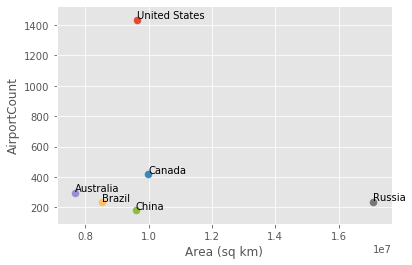

In [70]:
#gp=gp_joined.toPandas()
gp=gp_joined.filter(gp_joined['Area (sq km)'] > 5e6).toPandas()
ax=gp.plot.scatter('Area (sq km)', 'AirportCount')
for k, v in gp.iterrows():
    x=v['Area (sq km)']
    y=v['AirportCount']
    label=v['Country']
    plt.scatter(x,y,s=50)
    plt.text(x,y+10.0,label)

In [12]:
# TODO wykrycie niepasujących nazw państwa i ujednolicenie wartości 

# Zadanie 3

In [50]:
# TODO


In [51]:
a.printSchema

<bound method DataFrame.printSchema of DataFrame[country: string, count(airport): bigint]>

# Zadanie 4

In [22]:
# TODO